In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import open_clip
from datasets import load_dataset
from tinet_labels import i2d

import os
import numpy as np
import argparse
from tqdm import tqdm
# import ray
import matplotlib.pyplot as plt
import random

/home/rsaxena2/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VANILLA = 'vanilla'
CLIP = 'clip'
CLIP_S = 'ViT-B-32'
CLIP_M = 'ViT-L-14'
CLIP_L = 'ViT-H-14'
C10 = 'c10'
C100 = 'c100'
TINET = 'tinet'
MODEL_SAVEDIR = '/data/rsaxena2/distill_models'
RESNET18 = 'resnet18'
RESNET34 = 'resnet34'

# EDIT THESE!!!
# SAVE_NAME = '{DATASET}_{STUDENT}_{TRAIN_TYPE}_{RUN_NAME}
RUN_NAME = 'debug_run'
DATASET = C10
DATASET_PROP = 100
DISTILL_TEMP = 0.2
STUDENT_MODEL = RESNET18
USE_FED = False
NUM_STEPS = 50
TYPE = VANILLA
CLIP_VERSION = CLIP_S
NUM_EPOCHS = 30
OPTIM_CLASS = optim.AdamW
USE_COSINE_ANNEALING = True
STARTING_LEARNING_RATE = 3e-4
T_MAX = 100
OPTIM_PARAMS = {'lr' : 3e-4}


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_noise_train = transforms.Compose([
    transforms.ColorJitter(contrast=0.5, brightness=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_clip = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_noise_test = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ColorJitter(contrast=0.5, brightness=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_noise2_test = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

tinet_resize = transforms.Resize((32, 32))

In [3]:
tr_dataset = load_dataset(
    'cifar10',
    cache_dir='/data/rsaxena2/datasets/',
    split='train'
)
te_dataset = load_dataset(
    'cifar10',
    cache_dir='/data/rsaxena2/datasets/',
    split='test'
)
IMG_KEY = 'img'
LABEL_KEY = 'label'
NUM_CLASSES = 10
TR_BATCH_SIZE = 128

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [30]:
# regular test acc
def get_c10_test_acc(net, te_dataset, device):
    batch_size = 128
    total_correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for i in range(0, len(te_dataset), batch_size):
            i_end = min(i + batch_size, len(te_dataset))
            images = torch.stack([transform_test(te_dataset[int(idx)]['img']) for idx in range(i, i_end)]).to(device)
            logits = net(images)
            label_pred = torch.argmax(logits, dim=-1).cpu()
            label_vals = torch.tensor(te_dataset[i : i_end]['label'])
            total_correct += torch.sum(label_pred == label_vals).item()
            total += len(label_vals)
    acc = total_correct/total * 100
    return acc

# noisy (IAI) acc
def get_c10_test_aug_acc(net, te_dataset, device):
    batch_size = 128
    total_correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for i in range(0, len(te_dataset), batch_size):
            i_end = min(i + batch_size, len(te_dataset))
            images = torch.stack([transform_noise_test(te_dataset[int(idx)]['img']) for idx in range(i, i_end)]).to(device)
            logits = net(images)
            label_pred = torch.argmax(logits, dim=-1).cpu()
            label_vals = torch.tensor(te_dataset[i : i_end]['label'])
            total_correct += torch.sum(label_pred == label_vals).item()
            total += len(label_vals)
    acc = total_correct/total * 100
    return acc

# noisy (other) acc
def get_c10_test_aug2_acc(net, te_dataset, device):
    batch_size = 128
    total_correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for i in tqdm(range(0, len(te_dataset), batch_size)):
            i_end = min(i + batch_size, len(te_dataset))
            images = torch.stack([transform_noise2_test(te_dataset[int(idx)]['img']) for idx in range(i, i_end)]).to(device)
            logits = net(images)
            label_pred = torch.argmax(logits, dim=-1).cpu()
            label_vals = torch.tensor(te_dataset[i : i_end]['label'])
            total_correct += torch.sum(label_pred == label_vals).item()
            total += len(label_vals)
    acc = total_correct/total * 100
    return acc

def get_c10_c_acc(shift, model):
    temp_X = np.load('/data/rsaxena2/datasets/CIFAR-10-C/{}.npy'.format(shift))
    norm_transform = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    temp_X = torch.tensor(temp_X.transpose((0, 3, 1, 2))/255, dtype=torch.float32)
    temp_X = norm_transform(temp_X)
    temp_Y = torch.tensor(np.load('/data/rsaxena2/datasets/CIFAR-10-C/labels.npy'))
    
    batch_size = 128
    total_correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for i in tqdm(range(0, len(temp_X), batch_size)):
            i_end = min(i + batch_size, len(temp_X))
            images = temp_X[list(range(i, i_end))].to(device)
            logits = model(images)
            label_pred = torch.argmax(logits, dim=-1).cpu()
            label_vals = temp_Y[list(range(i, i_end))]
            total_correct += torch.sum(label_pred == label_vals).item()
            total += len(label_vals)
    acc = total_correct/total * 100
    return acc

def get_all_shifts_acc(model):
    EASY_C_SHIFTS = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur']
    MEDIUM_C_SHIFTS = ['jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']
    HARD_C_SHIFTS = ['gaussian_noise', 'glass_blur', 'impulse_noise', 'shot_noise']
    INET_C_SHIFTS = ['brightness', 'contrast', 'elastic_transform', 'fog', 
                    'frost', 'jpeg_compression', 'pixelate', 'snow']
    ALL_C_SHIFTS = EASY_C_SHIFTS + MEDIUM_C_SHIFTS + HARD_C_SHIFTS
    info = {}
    for shift in tqdm(ALL_C_SHIFTS):
        info[shift] = get_c10_c_acc(shift, model)
    avg_acc = np.mean(list(info.values()))
    return info, avg_acc

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [9]:
model = ResNet18(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load('/data/rsaxena2/distill_models/c10_resnet18_prop100_epc30_optAdamW_vanilla_debug_run_final_model.pth'))
model = model.to(device)
print_trainable_parameters(model)

trainable params: 11173962 || all params: 11173962 || trainable%: 100.00


In [57]:
# regular tr: 50k
# noisy fine-tuning: 5k [this is also very optimistic]
NOISY_DATA_LEN = 5000

def get_resnet_ft_traj(lr, path, num_tr_epc=10):
    
    tr_data_sizes = np.linspace(0, NOISY_DATA_LEN, 6)
    info = {}
    
    # special handling for 0 size
    # load the model
    net = ResNet18(num_classes=NUM_CLASSES)
    net.load_state_dict(torch.load(path))
    net = net.to(device)
    this_size_info = {
        'loss_traj' : [],
        'clean_acc_traj' : [get_c10_test_acc(net, te_dataset, device)],
        'noisy_acc_traj' : [get_c10_test_aug_acc(net, te_dataset, device)]
    }
    info[0] = this_size_info
    
    for tr_size in tr_data_sizes[1:]:
        tr_size = int(tr_size)
        
        # load the model
        net = ResNet18(num_classes=NUM_CLASSES)
        net.load_state_dict(torch.load(path))
        net = net.to(device)
    
        # train for a certain number of epochs with the lr
        loss_traj = []
        clean_acc_traj = []
        noisy_acc_traj = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(net.parameters(), lr=lr)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        
        all_train_idxs = np.arange(len(tr_dataset))
        np.random.shuffle(all_train_idxs)
        all_train_idxs = all_train_idxs[ : tr_size]

        for epoch in range(num_tr_epc):
            net.train()
            train_loss = 0
            correct = 0
            total = 0
            np.random.shuffle(all_train_idxs)
            for idx in range(0, len(all_train_idxs), TR_BATCH_SIZE):
                idx_end = min(idx + TR_BATCH_SIZE, len(all_train_idxs))
                
                # get the input for the student model
                net_input = torch.stack([transform_noise_train(tr_dataset[int(i)][IMG_KEY]) for i in all_train_idxs[idx : idx_end]]).to(device)
                
                # if DATASET in [C10, C100]:
                #     net_input = torch.stack([transform_train(tr_dataset[int(i)][IMG_KEY]) for i in all_train_idxs[idx : idx_end]]).to(device)
                # elif DATASET in [TINET]:
                #     net_input = torch.stack([transform_train(tinet_resize(tr_dataset[int(i)][IMG_KEY].convert('RGB'))) for i in all_train_idxs[idx : idx_end]]).to(device)
                
                # get the actual targets
                targets = torch.tensor([tr_dataset[int(i)][LABEL_KEY] for i in all_train_idxs[idx : idx_end]]).to(device)
                
                # 0-grad + forward pass
                optimizer.zero_grad()
                outputs = net(net_input)
                
                # get loss 
                if TYPE == VANILLA:
                    loss = criterion(outputs, targets)
                    
                loss.backward()
                optimizer.step()

                # append to the loss and acc trajectories
                train_loss += loss.item()
                loss_traj.append(loss.item())
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            # get the test accuracies
            clean_acc = get_c10_test_acc(net, te_dataset, device)
            noisy_acc = get_c10_test_aug_acc(net, te_dataset, device)
            clean_acc_traj.append(clean_acc)
            noisy_acc_traj.append(noisy_acc)

        this_size_info = {
            'loss_traj' : loss_traj,
            'clean_acc_traj' : clean_acc_traj,
            'noisy_acc_traj' : noisy_acc_traj
        }
        info[tr_size] = this_size_info
    
    return info
        

In [58]:
# consider vanilla resnet: /data/rsaxena2/distill_models/c10_resnet18_prop100_epc30_optAdamW_vanilla_debug_run_final_model.pth
# optim: AdamW 3e-4
num_tr_epc = 10
info = get_resnet_ft_traj(3e-4, '/data/rsaxena2/distill_models/c10_resnet18_prop100_epc30_optAdamW_vanilla_debug_run_final_model.pth', num_tr_epc=num_tr_epc)

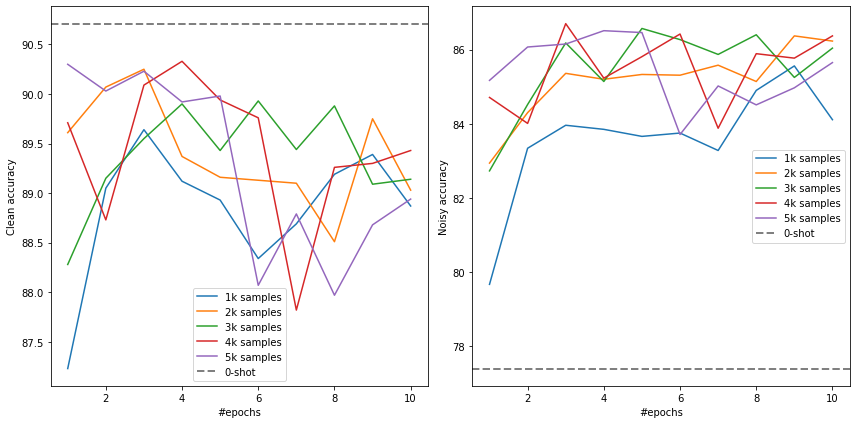

In [59]:
epc_range = np.arange(1, 1 + num_tr_epc)

plt.figure(figsize=(12, 6)) 

plt.subplot(1, 2, 1)
plt.plot(epc_range, info[1000]['clean_acc_traj'], label='1k samples')
plt.plot(epc_range, info[2000]['clean_acc_traj'], label='2k samples')
plt.plot(epc_range, info[3000]['clean_acc_traj'], label='3k samples')
plt.plot(epc_range, info[4000]['clean_acc_traj'], label='4k samples')
plt.plot(epc_range, info[5000]['clean_acc_traj'], label='5k samples')
plt.axhline(info[0]['clean_acc_traj'][0], color='gray', linestyle='--', linewidth=2, label='0-shot')
plt.xlabel('#epochs')
plt.ylabel('Clean accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epc_range, info[1000]['noisy_acc_traj'], label='1k samples')
plt.plot(epc_range, info[2000]['noisy_acc_traj'], label='2k samples')
plt.plot(epc_range, info[3000]['noisy_acc_traj'], label='3k samples')
plt.plot(epc_range, info[4000]['noisy_acc_traj'], label='4k samples')
plt.plot(epc_range, info[5000]['noisy_acc_traj'], label='5k samples')
plt.axhline(info[0]['noisy_acc_traj'][0], color='gray', linestyle='--', linewidth=2, label='0-shot')
plt.xlabel('#epochs')
plt.ylabel('Noisy accuracy')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [60]:
# consider vanilla resnet: /data/rsaxena2/distill_models/c10_resnet18_prop100_epc30_optAdamW_vanilla_debug_run_final_model.pth
# optim: AdamW 3e-4
num_tr_epc = 10
info = get_resnet_ft_traj(1e-4, '/data/rsaxena2/distill_models/c10_resnet18_prop100_epc30_optAdamW_vanilla_debug_run_final_model.pth', num_tr_epc=num_tr_epc)

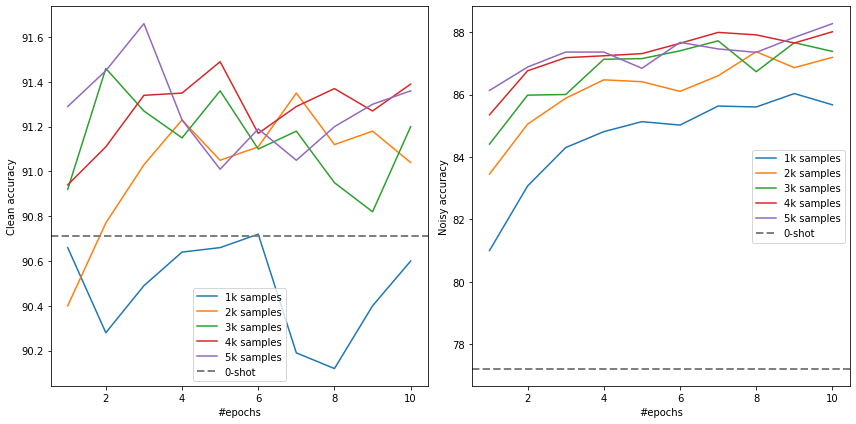

In [61]:
epc_range = np.arange(1, 1 + num_tr_epc)

plt.figure(figsize=(12, 6)) 

plt.subplot(1, 2, 1)
plt.plot(epc_range, info[1000]['clean_acc_traj'], label='1k samples')
plt.plot(epc_range, info[2000]['clean_acc_traj'], label='2k samples')
plt.plot(epc_range, info[3000]['clean_acc_traj'], label='3k samples')
plt.plot(epc_range, info[4000]['clean_acc_traj'], label='4k samples')
plt.plot(epc_range, info[5000]['clean_acc_traj'], label='5k samples')
plt.axhline(info[0]['clean_acc_traj'][0], color='gray', linestyle='--', linewidth=2, label='0-shot')
plt.xlabel('#epochs')
plt.ylabel('Clean accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epc_range, info[1000]['noisy_acc_traj'], label='1k samples')
plt.plot(epc_range, info[2000]['noisy_acc_traj'], label='2k samples')
plt.plot(epc_range, info[3000]['noisy_acc_traj'], label='3k samples')
plt.plot(epc_range, info[4000]['noisy_acc_traj'], label='4k samples')
plt.plot(epc_range, info[5000]['noisy_acc_traj'], label='5k samples')
plt.axhline(info[0]['noisy_acc_traj'][0], color='gray', linestyle='--', linewidth=2, label='0-shot')
plt.xlabel('#epochs')
plt.ylabel('Noisy accuracy')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()